In [39]:
library(tidyverse)
library(repr)
library(tidymodels)
library(kknn)
options(repr.matrix.max.rows = 6)

In [40]:
 install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [41]:
heart_disease <- read_csv("https://raw.githubusercontent.com/Mikeee12138/Group-Project-dsci100/main/processed.cleveland.data", col_names = FALSE)

colnames(heart_disease) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
heart_disease <- heart_disease  |>
mutate(num = as_factor(num))
heart_disease

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [42]:
heart_disease_split <- initial_split(heart_disease , prop = 0.75, strata = num)  
heart_disease_train <- training(heart_disease_split)   
heart_disease_test<- testing(heart_disease_split)
heart_disease_train

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,0,4,128,205,0,1,130,1,2.0,2,1.0,7.0,3
59,1,4,164,176,1,2,90,0,1.0,2,2.0,6.0,3
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3


In [43]:
heart_disease_recipe <- recipe(num ~ age + trestbps + chol , data = heart_disease_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) # No Answer - remove if you provide an answer
heart_disease_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

! Fold3: internal:
  There were 20 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 19 ...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4076371,5,0.013531304,Preprocessor1_Model01
2,accuracy,multiclass,0.4076371,5,0.013531304,Preprocessor1_Model02
3,accuracy,multiclass,0.4385896,5,0.008851981,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
18,accuracy,multiclass,0.5445959,5,0.008750098,Preprocessor1_Model18
19,accuracy,multiclass,0.5312450,5,0.005677136,Preprocessor1_Model19
20,accuracy,multiclass,0.5225452,5,0.007387030,Preprocessor1_Model20


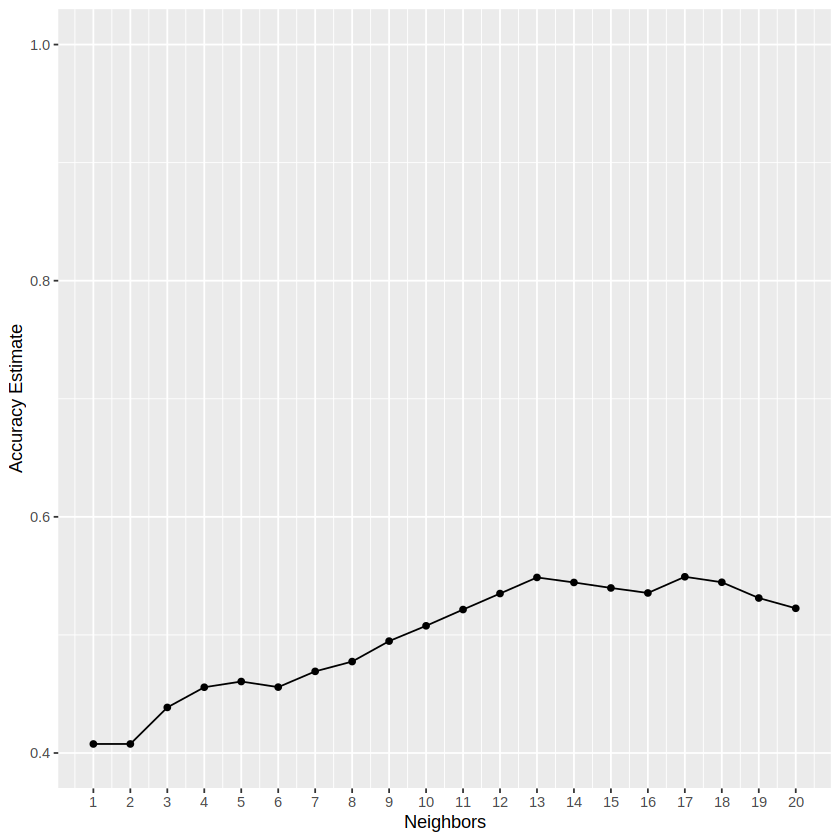

In [44]:
heart_disease_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = num)

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_results <- workflow() |>
      add_recipe(heart_disease_recipe) |>
       add_model(heart_disease_spec) |>
       tune_grid(resamples = heart_disease_vfold, grid = k_vals) |>
       collect_metrics()

accuracies <- knn_results |> 
       filter(.metric == "accuracy")
accuracies

max_accuracies <- summarize(accuracies, accuracy = max(mean))
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(1, 20, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis # No Answer - remove if you provide an answer
accuracy_versus_k